# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass



## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define layers for MNIST classification
        self.fc1 = nn.Linear(28 * 28, 128) #   # First fully connected layer (input to hidden layer)
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer (hidden layer to another hidden layer)
        self.fc3 = nn.Linear(64, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        # Flatten the input image from 28x28 to a vector of size 784
        # Here we define what we do with layers
        # We can add dropouts for overfittings. 
        # Dropout randomly sets a fraction of input units to 0 at each update during training time,
        # which helps prevent overfitting.
        # x = F.dropout(x, training=self.training)  # Apply dropout during training [It will randomly set some values to 0]
        
        # Flatten the input image from 28x28 to a vector of size 784 (which is the input to the first fully connected layer)
        # Here we transform the input data from a 2D tensor (image) to a 1D tensor (vector)
        # This is because the fully connected layer expects a 1D input.
        # The view function reshapes the tensor to have a new shape. 28*28 is the total number of pixels in an image. 784 is the number of neurons in the first fully connected layer. 1 is the batch size, which is not needed for this case.
        x = x.view(-1, 28 * 28)
        
        # Apply ReLU activation after each layer
        x = F.relu(self.fc1(x))  # First hidden layer # Relu is a function 
        x = F.relu(self.fc2(x))  # Second hidden layer
        
        # Output layer with log-softmax for classification [It will give me prob for classes for all the 10 classes]
        # Then we get the argmax which will give me the max probability of the 10 classes
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)  # Return log probabilities [Here I got the max prob]
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x)
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Simplified architecture with fewer neurons and layers
#         self.fc1 = nn.Linear(28 * 28, 256)  # First fully connected layer
#         self.fc2 = nn.Linear(256, 128)  # Second fully connected layer
#         self.fc3 = nn.Linear(128, 64)  # Third fully connected layer
#         self.fc4 = nn.Linear(64, 10)  # Output layer (10 classes)

#         # Batch normalization layers
#         self.bn1 = nn.BatchNorm1d(256)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.bn3 = nn.BatchNorm1d(64)

#         # Dropout for regularization (lower dropout rate)
#         self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = x.view(-1, 28 * 28)  # Flatten the input image

#         # First layer with batch normalization, ReLU, and dropout
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)

#         # Second layer
#         x = F.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)

#         # Third layer
#         x = F.relu(self.bn3(self.fc3(x)))
#         x = self.dropout(x)

#         # Output layer with log-softmax
#         x = self.fc4(x)
#         return F.log_softmax(x, dim=1)
    
     
def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [3]:

@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [4]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304324

Test set: Average loss: 2.1982, Accuracy: 2845/10000 (28%)



# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

Training model with 32 neurons in hidden layer.
Test results -> Loss: 0.2055, Accuracy: 93.87%
Test results -> Loss: 0.1525, Accuracy: 95.39%
Test results -> Loss: 0.1304, Accuracy: 96.22%
Test results -> Loss: 0.1231, Accuracy: 96.29%
Test results -> Loss: 0.1229, Accuracy: 96.34%
Test results -> Loss: 0.1140, Accuracy: 96.65%
Test results -> Loss: 0.1225, Accuracy: 96.32%
Test results -> Loss: 0.1032, Accuracy: 96.89%
Test results -> Loss: 0.1152, Accuracy: 96.54%
Test results -> Loss: 0.1116, Accuracy: 96.70%
Test results -> Loss: 0.1174, Accuracy: 96.62%
Test results -> Loss: 0.1109, Accuracy: 96.73%
Test results -> Loss: 0.1120, Accuracy: 96.81%
Test results -> Loss: 0.1165, Accuracy: 96.68%
Test results -> Loss: 0.1184, Accuracy: 96.68%
Test results -> Loss: 0.1225, Accuracy: 96.52%
Test results -> Loss: 0.1225, Accuracy: 96.80%
Test results -> Loss: 0.1351, Accuracy: 96.51%
Test results -> Loss: 0.1298, Accuracy: 96.80%
Test results -> Loss: 0.1338, Accuracy: 96.45%
Test results

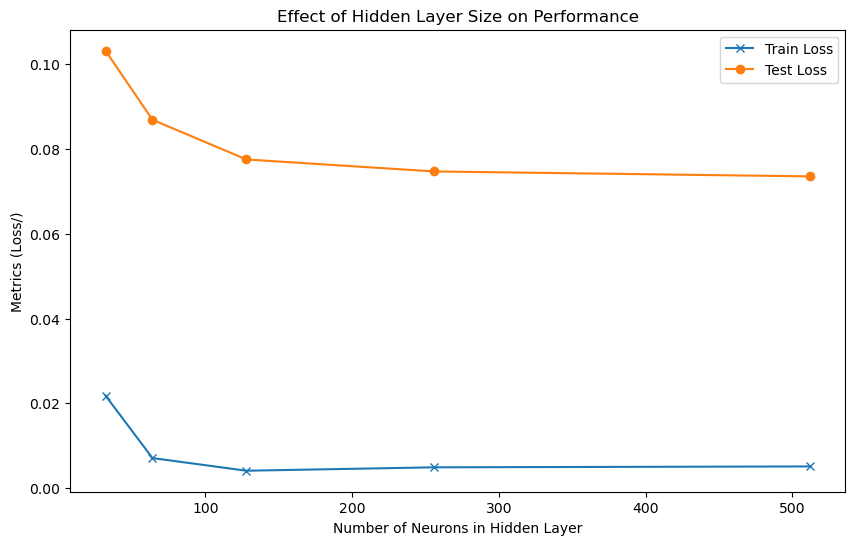

In [55]:
## CHAT GPT GOOD CODE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define a single hidden layer network with variable neurons
class SingleHiddenLayerNet(nn.Module):
    def __init__(self, num_neurons):
        super(SingleHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, num_neurons)  # Single hidden layer
        self.fc2 = nn.Linear(num_neurons, 10)  # Output layer (10 classes for MNIST)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input images
        x = F.relu(self.fc1(x))  # Activation function for the hidden layer
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)  # Log-softmax for classification


# Step 2: Train the model with convergence stopping and max epochs
def execute_training_process(params, device, train_data_loader, test_data_loader, hidden_layer_size, stop_threshold=1e-4, max_epochs=30):
    model = SingleHiddenLayerNet(hidden_layer_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    prev_train_loss = float('inf')
    prev_test_loss = float('inf')

    recorded_train_losses = []
    recorded_test_losses = []
    test_accuracy = []

    no_improvement_counter = 0  # Stop training after 2 epochs with no improvement

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        accumulated_train_loss = 0

        for batch_data, batch_target in train_data_loader:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)
            optimizer.zero_grad()
            output = model(batch_data)
            loss = F.nll_loss(output, batch_target)
            loss.backward()
            optimizer.step()
            accumulated_train_loss += loss.item()

        avg_train_loss = accumulated_train_loss / len(train_data_loader)
        recorded_train_losses.append(avg_train_loss)

        # Testing phase
        avg_test_loss, acc = evaluate_model_performance(model, device, test_data_loader)
        recorded_test_losses.append(avg_test_loss)
        test_accuracy.append(acc)

        # Stopping criteria based on convergence
        if abs(prev_train_loss - avg_train_loss) < stop_threshold and abs(prev_test_loss - avg_test_loss) < stop_threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if no_improvement_counter >= 2:  # Stop after 2 epochs with minimal improvement
            print(f"Training stopped due to convergence at epoch {epoch+1} for hidden layer size {hidden_layer_size}")
            break

        prev_train_loss = avg_train_loss
        prev_test_loss = avg_test_loss

    return min(recorded_train_losses), min(recorded_test_losses)


# Step 3: Run multiple experiments with varying hidden layer sizes
def evaluate_different_hidden_layer_sizes(params, device, train_data_loader, test_data_loader):
    neuron_counts = [32, 64, 128, 256, 512]  # Different hidden layer sizes
    train_losses = []
    test_losses = []
    

    for num_neurons in neuron_counts:
        print(f"Training model with {num_neurons} neurons in hidden layer.")
        train_loss, test_loss = execute_training_process(params, device, train_data_loader, test_data_loader, num_neurons)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
   

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(neuron_counts, train_losses, label="Train Loss", marker='x')
    plt.plot(neuron_counts, test_losses, label="Test Loss", marker='o')
    
    plt.xlabel("Number of Neurons in Hidden Layer")
    plt.ylabel("Metrics (Loss/)")
    plt.title("Effect of Hidden Layer Size on Performance")
    plt.legend()
    plt.show()


def evaluate_model_performance(model, device, test_data_loader):
    model.eval()
    accumulated_test_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_data, batch_target in test_data_loader:
            batch_data, batch_target = batch_data.to(device), batch_target.to(device)
            output = model(batch_data)
            accumulated_test_loss += F.nll_loss(output, batch_target, reduction="sum").item()
            predicted = output.argmax(dim=1, keepdim=True)
            correct_predictions += predicted.eq(batch_target.view_as(predicted)).sum().item()
            total_samples += batch_target.size(0)

    avg_test_loss = accumulated_test_loss / total_samples
    accuracy = 100.0 * correct_predictions / total_samples

    print(f"Test results -> Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return avg_test_loss, accuracy


# Set up the training parameters
@dataclass
class TrainingParams:
    """Class to store training parameters."""
    batch_size: int = 64
    test_batch_size: int = 1000
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    use_cuda: bool = True
    use_mps: bool = False
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = False


def configure_device_and_loaders(params):
    use_cuda = params.use_cuda and torch.cuda.is_available()
    use_mps = params.use_mps and torch.backends.mps.is_available()

    torch.manual_seed(params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((params.normalizer_mean,), (params.normalizer_std,))
    ])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST("../data", train=True, download=True, transform=data_transform),
        batch_size=params.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST("../data", train=False, transform=data_transform),
        batch_size=params.test_batch_size)

    return device, train_loader, test_loader


# Example usage
params = TrainingParams()
device, train_loader, test_loader = configure_device_and_loaders(params)

# Evaluate models with different hidden layer sizes
evaluate_different_hidden_layer_sizes(params, device, train_loader, test_loader)

Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

Training with 1 hidden layers
Training with 2 hidden layers
Training with 3 hidden layers
Training with 4 hidden layers
Training with 5 hidden layers


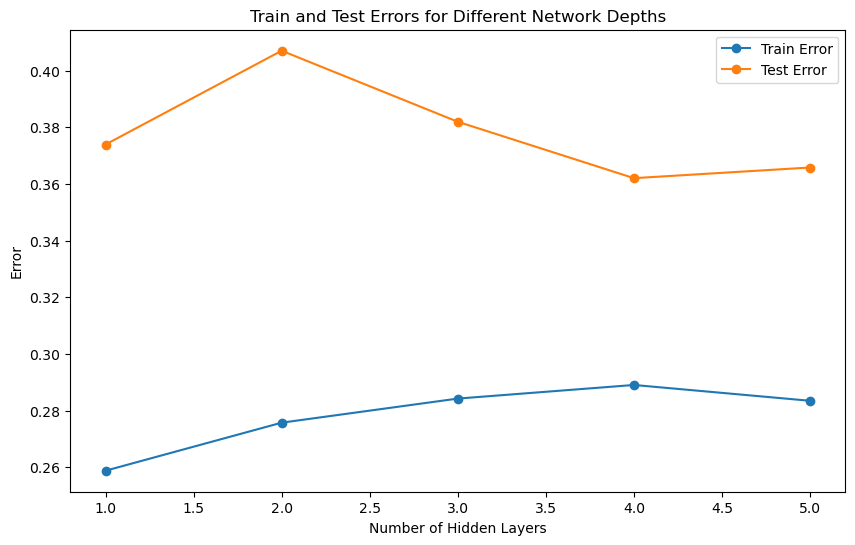

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


class MultiLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))  

        # Add intermediate hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
        
        layers.append(nn.Linear(hidden_size, output_size))  
        self.model = nn.Sequential(*layers)  

    def forward(self, x):
        x = x.view(-1, 28 * 28)  
        x = self.model(x)  
        return F.log_softmax(x, dim=1)  



def train_until_convergence_depth(training_params, device, train_loader, test_loader, num_layers, stop_threshold=1e-4, max_epochs=30):
    model = MultiLayerNet(28 * 28, 500, 10, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    prev_train_loss = float('inf')
    prev_test_loss = float('inf')
    
    train_errors = []
    test_errors = []
    
    no_improvement_counter = 0  

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_errors.append(avg_train_loss)

        
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        avg_test_loss = test_loss / len(test_loader.dataset)
        test_errors.append(avg_test_loss)

        
        if abs(prev_train_loss - avg_train_loss) < stop_threshold and abs(prev_test_loss - avg_test_loss) < stop_threshold:
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if no_improvement_counter >= 2:  
            print(f"Convergence reached at epoch {epoch+1} for network with {num_layers} hidden layers.")
            break

        prev_train_loss = avg_train_loss
        prev_test_loss = avg_test_loss

    return min(train_errors), min(test_errors)  



def explore_depth_convergence(training_params, device, train_loader, test_loader):
    num_layers_list = [1, 2, 3, 4, 5] 
    train_errors = []
    test_errors = []

    for num_layers in num_layers_list:
        print(f"Training with {num_layers} hidden layers")
        train_error, test_error = train_until_convergence_depth(
            training_params, device, train_loader, test_loader, num_layers
        )
        train_errors.append(train_error)
        test_errors.append(test_error)

    # Step 4: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(num_layers_list, train_errors, label="Train Error", marker='o')
    plt.plot(num_layers_list, test_errors, label="Test Error", marker='o')
    plt.xlabel("Number of Hidden Layers")
    plt.ylabel("Error")
    plt.title("Train and Test Errors for Different Network Depths")
    plt.legend()
    plt.show()


# Example usage:
training_params = TrainingParameters(epochs=30, dry_run=False)  


device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)


explore_depth_convergence(training_params, device, train_loader, test_loader)